# ECN Queries

for the MAMI Path Transparency Observatory at https://v3.pto.mami-project.eu

#### Configuration

If you have an API token with query submission permissions, enter it here, and you can submit queries.

In [1]:
token = None

Now some imports and useful functions

In [2]:
import ptoclient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


def pivot_condition_time(df, prefix, aspect, states):
    """
    Given a dataframe counts of conditions (states of one or more aspects) 
    over a time series, pivot to a time-indexed table with a column for 
    each state.
    
    """
    
    aspect_df = df[df['condition'].map(lambda x: x.startswith(".".join((prefix,aspect))))]
    
    total_df = aspect_df.groupby('time').sum().loc[:,["count"]]
    total_df.columns = ['total']
    total_df['time'] = total_df.index
    
    aspect_df = aspect_df.join(total_df, on="time", rsuffix="_")
    del(aspect_df['time_'])
    
    pivot_df = aspect_df.groupby('time').first().loc[:,['total']]
    for c in states:
        cseries = aspect_df[aspect_df['condition'] == ".".join((prefix,aspect,c))]
        cseries.index = cseries['time']
        cseries = cseries.loc[:,['count']]
        cseries.columns = [c]
        pivot_df = pd.concat([pivot_df, cseries], axis=1)
    
    return pivot_df.fillna(0)


#### Create a client to access the PTO

The client object encapsulates a base URL and an API token, and can be used to access queries and observations on the given instance of the PTO.

In [3]:
c = ptoclient.PTOClient("https://v3.pto.mami-project.eu/", token)

### Group all ECN multipoint condition counts by week 

Generate time series aggregates of ECN negotiation and ECN connectivity for the full dataset for which we have multipoint observations, then pivot those tables to generate plots.

First, retrieve the query for all multipoint conditions over time from the PTO; dump metadata for the query.

In [4]:
# This query was created with the following submit command:
# q_multipoint = c.submit_query(
#                 ptoclient.PTOQuerySpec().time("2014-01-01","2017-04-01")
#                                      .condition("ecn.multipoint.*")
#                                      .group_by_condition().time_series_week())

q_multipoint = c.retrieve_query(url='https://v3.pto.mami-project.eu/query/9d0a16b4fbb090b661e33140c847b999a8907a49058f21795ab68cdeb6784c95')

multipoint_df = q_multipoint.results()
multipoint_df.columns = ["count","condition","time"]
multipoint_df["time"] = pd.to_datetime(multipoint_df["time"])

q_multipoint.metadata()

{'__completed': '2018-05-24T20:23:32+02:00',
 '__created': '2018-05-24T20:09:09+02:00',
 '__encoded': 'time_start=2014-01-01T00%3A00%3A00Z&time_end=2017-04-01T00%3A00%3A00Z&condition=ecn.multipoint.connectivity.broken&condition=ecn.multipoint.connectivity.offline&condition=ecn.multipoint.connectivity.path_dependent&condition=ecn.multipoint.connectivity.transient&condition=ecn.multipoint.connectivity.unstable&condition=ecn.multipoint.connectivity.works&condition=ecn.multipoint.negotiation.failed&condition=ecn.multipoint.negotiation.path_dependent&condition=ecn.multipoint.negotiation.reflected&condition=ecn.multipoint.negotiation.succeeded&condition=ecn.multipoint.negotiation.unstable&group=condition&group=week',
 '__executed': '2018-05-24T20:09:09+02:00',
 '__link': 'https://v3.pto.mami-project.eu/query/9d0a16b4fbb090b661e33140c847b999a8907a49058f21795ab68cdeb6784c95',
 '__modified': '2018-05-24T20:23:32+02:00',
 '__result': 'https://v3.pto.mami-project.eu/query/9d0a16b4fbb090b661e33140

Create pivot tables, showing the counts for each state for negotiation and connectivity impact

In [5]:
multipoint_nego_pivot = pivot_condition_time(multipoint_df, "ecn.multipoint", "negotiation",
                                             ('succeeded','failed','reflected','path_dependent','unstable'))
multipoint_nego_pivot

,total,succeeded,failed,reflected,path_dependent,unstable
time,,,,,,
2014-08-25,598869,333803,260462,2043.0,2520,41
2014-09-01,598869,332100,261759,2020.0,2938,52
2014-09-08,598869,331663,262356,2017.0,2784,49
2016-07-18,644060,459392,180980,2529.0,1117,42
2016-07-25,642071,461278,177202,2521.0,956,114
2016-08-01,640725,461879,175356,2498.0,865,127
2016-08-08,641768,462528,175470,2487.0,1171,112
2016-12-05,768401,582825,170581,0.0,413,14582
2016-12-12,769254,585159,169467,0.0,476,14152


In [6]:
multipoint_conn_pivot = pivot_condition_time(multipoint_df, "ecn.multipoint", "connectivity",
                                             ('works','broken','transient','offline','path_dependent','unstable'))
multipoint_conn_pivot

,total,works,broken,transient,offline,path_dependent,unstable
time,,,,,,,
2014-08-25,598869,587553,2318,37,7212,897,852
2014-09-01,598869,583583,2281,35,9803,1658,1509
2014-09-08,598869,583476,2312,50,10818,1109,1104
2016-07-18,644060,641984,19,40,1746,211,60
2016-07-25,642071,640027,22,33,1747,162,80
2016-08-01,640725,638694,25,37,1746,126,97
2016-08-08,641768,639535,23,29,1725,271,185
2016-12-05,768401,752863,1250,18,13238,619,413
2016-12-12,769254,754065,1198,14,12865,638,474


Normalize numbers to plot against total observations

In [7]:
multipoint_nego_pivot['succeeded_p'] = multipoint_nego_pivot['succeeded'] / multipoint_nego_pivot['total']
multipoint_conn_pivot['broken_p'] = multipoint_conn_pivot['broken'] / (multipoint_conn_pivot['total'] - multipoint_conn_pivot['offline'])
multipoint_conn_pivot['pdep_p'] = multipoint_conn_pivot['path_dependent'] / (multipoint_conn_pivot['total'] - multipoint_conn_pivot['offline'])

And generate a plot (if you're here because you're reading the paper version of this, hi! You might recognize this plot).

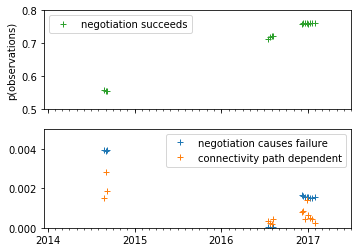

In [8]:
f, (ax1, ax2) = plt.subplots(2,1,sharex=True, figsize=(5.5,4))
ax1.plot(multipoint_nego_pivot.loc[:,["succeeded_p"]],"+",color="tab:green",label="negotiation succeeds")
ax1.set_ylim(0.5,0.8)
ax1.legend()
ax1.set_ylabel("p(observations)")

ax2.plot(multipoint_conn_pivot.loc[:,["broken_p"]],"+",label="negotiation causes failure")
ax2.plot(multipoint_conn_pivot.loc[:,["pdep_p"]],"+",label="connectivity path dependent")

ax2.set_ylim(0,0.005)
ax2.set_xlim(pd.to_datetime("2013-12-15"),pd.to_datetime("2017-07-01"))
ax2.legend()

ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_minor_locator(mdates.MonthLocator())

f.savefig("ecnresult.pdf")

### Generate counts of raw and derived observations in the database 

The following queries count first-stage as well as derived observations per year; we'll sum the counts to get total observation counts. We do this for the appropriate bit of the submitted paper.

In [9]:
# q_all_count = c.submit_query(
#                     ptoclient.PTOQuerySpec().time("2014-01-01","2018-01-01")
#                                      .condition("ecn.negotiation.*")
#                                      .condition("ecn.connectivity.*")
#                                      .condition("ecn.ipmark.*")
#                                      .time_series_year())
q_all_count = c.retrieve_query('https://v3.pto.mami-project.eu/query/80a720a924566b9d77e0cab57aac276eefff645fa03af386515ca9814664aa84')

In [10]:
q_all_count.results()["count"].sum()

448598576

In [11]:
q_derived_count = c.submit_query(
                    ptoclient.PTOQuerySpec().time("2014-01-01","2018-01-01")
                                     .condition("ecn.stable.*")
                                     .condition("ecn.multipoint.*")
                                     .time_series_year())
#q_derived_count = c.retrieve_query('https://v3.pto.mami-project.eu/query/80a720a924566b9d77e0cab57aac276eefff645fa03af386515ca9814664aa84')

In [12]:
q_derived_count.results()["count"].sum()

102323404

### Other example queries

List all observations where ECN connectivity failure appears to be path-dependent

In [13]:
# q_all_pathdep = c.submit_query(ptoclient.PTOQuerySpec()
#                                .time("2014-01-01","2018-01-01")
#                                .condition("ecn.multipoint.connectivity.path_dependent"))
q_all_pathdep = c.retrieve_query('https://v3.pto.mami-project.eu/query/8da2b65bd4f7cd8d56d90ddfcd85297e8aac54fcd0e04f0a0fa51b2937b3dc62')
q_all_pathdep.metadata()

{'__completed': '2018-05-25T16:10:35+02:00',
 '__created': '2018-05-25T16:03:31+02:00',
 '__encoded': 'time_start=2014-01-01T00%3A00%3A00Z&time_end=2018-01-01T00%3A00%3A00Z&condition=ecn.multipoint.connectivity.path_dependent',
 '__executed': '2018-05-25T16:03:31+02:00',
 '__link': 'https://v3.pto.mami-project.eu/query/8da2b65bd4f7cd8d56d90ddfcd85297e8aac54fcd0e04f0a0fa51b2937b3dc62',
 '__modified': '2018-05-25T16:10:35+02:00',
 '__result': 'https://v3.pto.mami-project.eu/query/8da2b65bd4f7cd8d56d90ddfcd85297e8aac54fcd0e04f0a0fa51b2937b3dc62/result',
 '__state': 'complete'}

In [14]:
q_all_pathdep.results()

,condition,path,set_id,time_end,time_start,value
0,ecn.multipoint.connectivity.path_dependent,* 178.33.224.30,103,2014-08-28T21:36:57Z,2014-08-28T21:28:30Z,3
1,ecn.multipoint.connectivity.path_dependent,* 85.25.27.196,103,2014-08-28T22:01:21Z,2014-08-28T21:53:26Z,3
2,ecn.multipoint.connectivity.path_dependent,* 85.25.138.49,103,2014-08-28T23:52:19Z,2014-08-28T23:47:04Z,3
3,ecn.multipoint.connectivity.path_dependent,* 143.248.5.153,103,2014-08-28T21:50:36Z,2014-08-28T21:42:22Z,3
4,ecn.multipoint.connectivity.path_dependent,* 186.202.122.75,103,2014-08-28T22:40:09Z,2014-08-28T22:34:31Z,3
5,ecn.multipoint.connectivity.path_dependent,* 85.25.197.237,103,2014-08-28T22:27:10Z,2014-08-28T22:20:16Z,3
6,ecn.multipoint.connectivity.path_dependent,* 164.109.105.205,103,2014-08-28T21:50:26Z,2014-08-28T21:42:13Z,3
7,ecn.multipoint.connectivity.path_dependent,* 85.25.200.72,103,2014-08-28T23:56:48Z,2014-08-28T23:51:36Z,3
8,ecn.multipoint.connectivity.path_dependent,* 190.192.160.69,103,2014-08-28T23:50:10Z,2014-08-28T23:45:00Z,3
9,ecn.multipoint.connectivity.path_dependent,* 62.75.196.60,103,2014-08-28T21:36:07Z,2014-08-28T21:27:42Z,3
